In [ ]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
!pip install pmdarima

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
crimes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Crimes_Jan2018_Nov2023.csv')
crimes.shape

(1408566, 17)

In [4]:
crimes

,Case Number,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,date,time,Weekday,Crime_Type
0,JG396236,2018-01-01 00:00:00,012XX W 101ST PL,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,0,0,2232,22,21.0,73.0,2018,2018-01-01,00:00:00,0,MISDEMEANOR
1,JD334537,2018-01-01 00:00:00,010XX W NEWPORT AVE,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,OTHER (SPECIFY),0,0,1924,19,44.0,6.0,2018,2018-01-01,00:00:00,0,MISDEMEANOR
2,JC513241,2018-01-01 00:00:00,052XX N RESERVE AVE,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,0,0,1614,16,41.0,76.0,2018,2018-01-01,00:00:00,0,INFRACTION
3,JD240441,2018-01-01 00:00:00,048XX N AVERS AVE,OFFENSE INVOLVING CHILDREN,CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,APARTMENT,0,1,1712,17,35.0,14.0,2018,2018-01-01,00:00:00,0,FELONY
4,JD341715,2018-01-01 00:00:00,049XX S TRIPP AVE,OFFENSE INVOLVING CHILDREN,AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY M...,APARTMENT,0,1,815,8,14.0,57.0,2018,2018-01-01,00:00:00,0,FELONY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408561,JG507012,2023-11-01 00:00:00,023XX N WOLCOTT AVE,MOTOR VEHICLE THEFT,THEFT / RECOVERY - AUTOMOBILE,STREET,0,0,1432,14,32.0,22.0,2023,2023-11-01,00:00:00,2,MISDEMEANOR
1408562,JG511130,2023-11-01 00:00:00,0000X E MONROE ST,MOTOR VEHICLE THEFT,AUTOMOBILE,HOTEL / MOTEL,0,0,112,1,34.0,32.0,2023,2023-11-01,00:00:00,2,MISDEMEANOR
1408563,JG513227,2023-11-01 00:00:00,089XX S HARPER AVE,THEFT,OVER $500,APARTMENT,0,0,413,4,8.0,48.0,2023,2023-11-01,00:00:00,2,MISDEMEANOR
1408564,JG522375,2023-11-01 00:00:00,092XX S PEORIA ST,OTHER OFFENSE,TELEPHONE THREAT,RESIDENCE,0,1,2223,22,21.0,73.0,2023,2023-11-01,00:00:00,2,INFRACTION


### **Daily Data**

In [5]:
daily_data = crimes.groupby('date').size().reset_index(name='Number_of_Crimes')

daily_data.drop(daily_data.tail(1).index,inplace=True)

In [6]:
daily_data.index = pd.to_datetime(daily_data['date'])
daily_data.index.freq = 'D'

### **Monthly Data**

In [32]:
monthly_data = daily_data.resample('M').sum(numeric_only=True)

### **Weekly Data**

In [30]:
weekly_data = daily_data.resample('W').sum(numeric_only=True)
weekly_data = weekly_data.iloc[:-1]

In [9]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

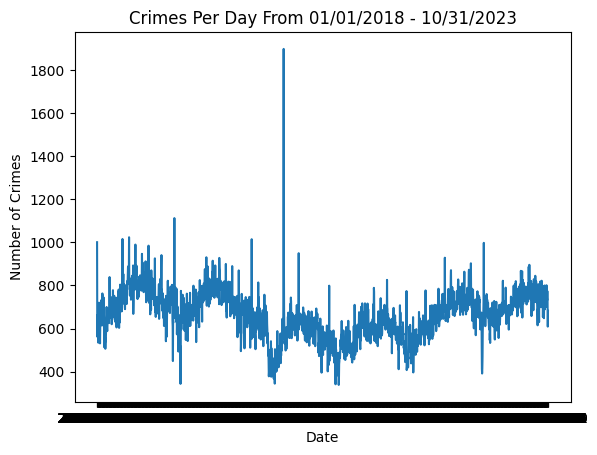

In [25]:
plt.plot(daily_data['date'], daily_data['Number_of_Crimes'])
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.title('Crimes Per Day From 01/01/2018 - 10/31/2023')
plt.show()

In [11]:
print(daily_data.nlargest(5, 'Number_of_Crimes'))

                  date  Number_of_Crimes
date                                    
2020-05-31  2020-05-31              1899
2019-01-01  2019-01-01              1113
2018-06-01  2018-06-01              1024
2018-05-01  2018-05-01              1016
2020-01-01  2020-01-01              1015


https://chicago.suntimes.com/crime/2020/6/8/21281998/chicago-deadliest-day-violence-murder-history-police-crime

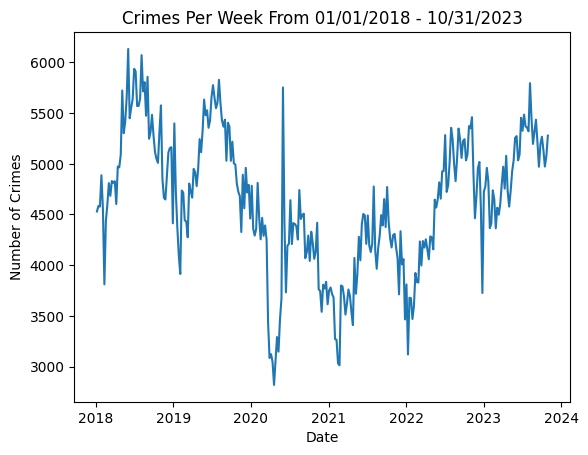

In [28]:
plt.plot(weekly_data.index, weekly_data['Number_of_Crimes'])
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.title('Crimes Per Week From 01/01/2018 - 10/31/2023')
plt.show()

## Decompose Weekly Data

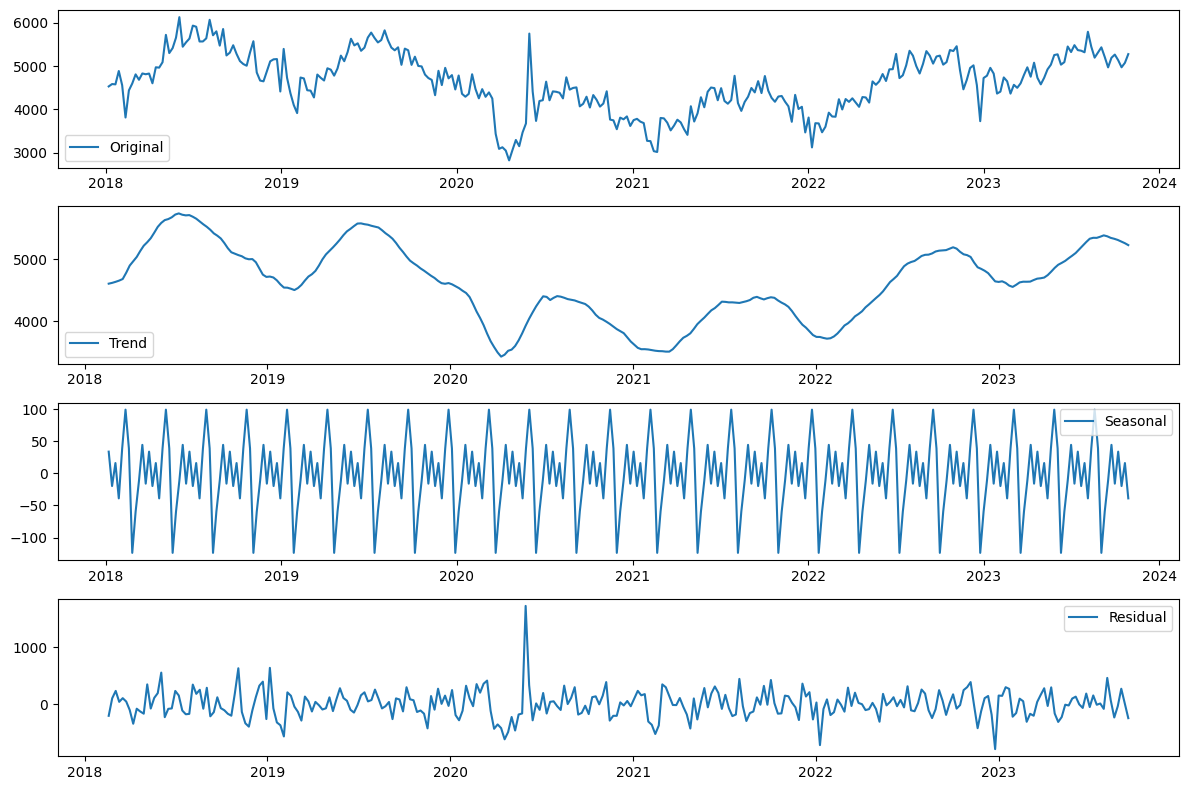

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assuming your DataFrame is already set up with 'date' as the index
# If not, use: daily_data.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))

result = seasonal_decompose(weekly_data['Number_of_Crimes'], model='additive', period=12)  # Assuming a yearly seasonality

plt.subplot(4, 1, 1)
plt.plot(weekly_data['Number_of_Crimes'], label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

### Autocorrelation plot exhibits **slow** decay, indicating the time series is **non-stationary**

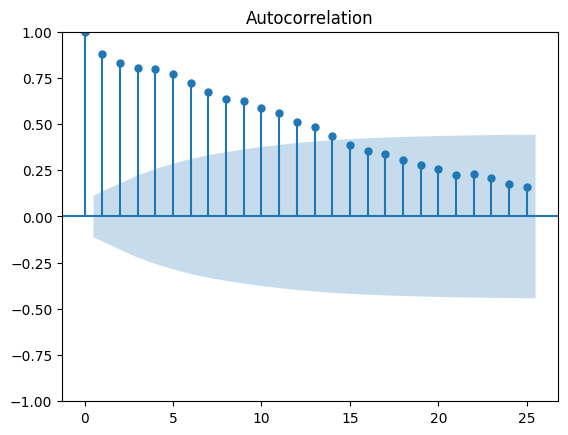

In [13]:
plot_acf(weekly_data['Number_of_Crimes'].dropna());

### **Augmented Dickey-Fuller (ADF)  Test for Stationarity**

In [14]:
adf_result = adfuller(weekly_data['Number_of_Crimes'])

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -2.1196521512901962
p-value: 0.2366861461277226


Null hypothesis $H_{0}$: A unit root exists; the series is non-stationary

Alternate hypothesis $H_{1}$: The series is stationary

The p-value is greater than signifiance level 0.05, so we fail to reject the null hypothesis.

Thus, the ADF test suggests the time series is **non-stationary**.

### ACF and PACF of Differences Series

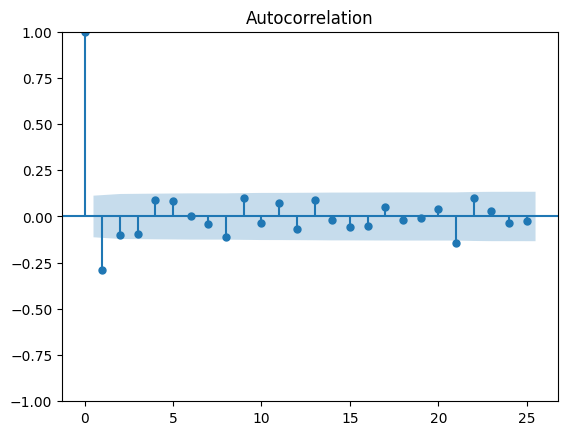

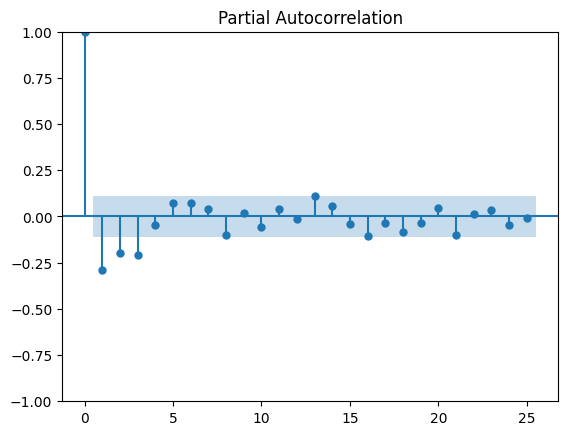

In [54]:
weekly_data['Number_of_Crimes_diff'] = weekly_data['Number_of_Crimes'].diff()

plot_acf(weekly_data['Number_of_Crimes_diff'].dropna());

plot_pacf(weekly_data['Number_of_Crimes_diff'].dropna());

## **Fitting the Models**

## ARIMA

In [15]:
# Split the data into training and testing sets
train_size = int(len(weekly_data) * 0.8)
train, test = weekly_data['Number_of_Crimes'][:train_size], weekly_data['Number_of_Crimes'][train_size:]

In [39]:
arima_model = ARIMA(train, order=(1, 1, 1))
arima_fit = arima_model.fit()

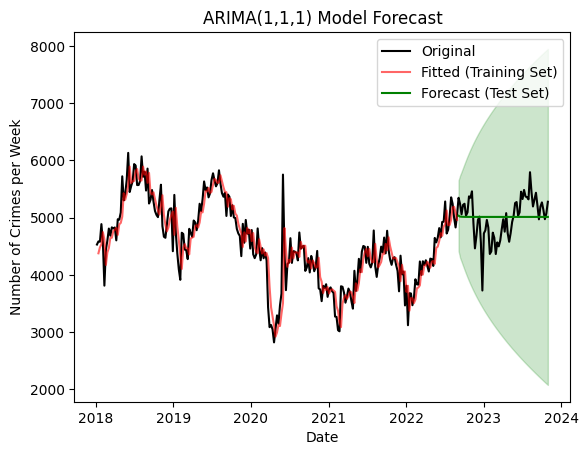

Mean Absolute Percentage Error (MAPE) on Test Set: 5.94%


In [40]:
forecast_arima = arima_fit.get_forecast(steps=len(test))

observed_test_values_arima = test.values
predicted_test_values_arima = forecast_arima.predicted_mean

# Get confidence intervals for the forecast on the test set
ci_test = forecast_arima.conf_int()

# Plot the original time series
plt.plot(weekly_data['Number_of_Crimes'], label='Original', color='black')

# Plot the fitted values on the training set
plt.plot(arima_fit.fittedvalues.index[1:], arima_fit.fittedvalues[1:], color='red', label='Fitted (Training Set)', alpha=0.6)

# Plot the forecasted values for the test set
plt.plot(test.index, predicted_test_values_arima, color='green', label='Forecast (Test Set)')

# Plot confidence intervals for the forecast on the test set
plt.fill_between(test.index, ci_test.iloc[:, 0], ci_test.iloc[:, 1], color='green', alpha=0.2)

plt.title('ARIMA(1,1,1) Model Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Crimes per Week')
plt.legend()
plt.show()

# Calculate MAPE
mape_test = np.mean(np.abs((observed_test_values_arima - predicted_test_values_arima) / np.maximum(1, observed_test_values_arima))) * 100

print(f'Mean Absolute Percentage Error (MAPE) on Test Set: {mape_test:.2f}%')

## SARIMA

In [58]:
# Split the data into training and testing sets
train_size = int(len(weekly_data) * 0.8)
train, test = weekly_data['Number_of_Crimes'][:train_size], weekly_data['Number_of_Crimes'][train_size:]

sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52))
sarima_fit = sarima_model.fit(disp=False)

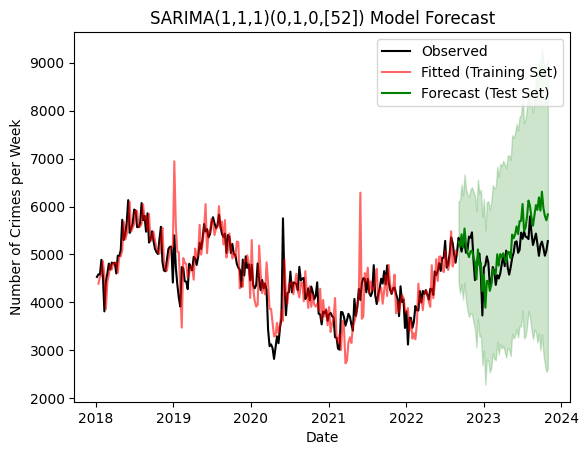

Mean Absolute Percentage Error (MAPE) on Test Set (SARIMA): 7.34%


In [59]:
# Get forecast for the test set
forecast_sarima = sarima_fit.get_forecast(steps=len(test))

observed_test_values_sarima = test.values
predicted_test_values_sarima = forecast_sarima.predicted_mean

# Get confidence intervals for the forecast on the test set
ci_test = forecast_sarima.conf_int()

# Plot the original time series
plt.plot(weekly_data['Number_of_Crimes'], label='Observed', color='black')

# Plot the fitted values on the training set
plt.plot(sarima_fit.fittedvalues.index[1:], sarima_fit.fittedvalues[1:], color='red', label='Fitted (Training Set)', alpha=0.6)

# Plot the forecasted values for the test set
plt.plot(test.index, forecast_sarima.predicted_mean, color='green', label='Forecast (Test Set)')

# Plot confidence intervals for the forecast on the test set
plt.fill_between(test.index, ci_test.iloc[:, 0], ci_test.iloc[:, 1], color='green', alpha=0.2)

plt.title('SARIMA(1,1,1)(0,1,0,[52]) Model Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Crimes per Week')
plt.legend()
plt.show()

mape_test_sarima = np.mean(np.abs((observed_test_values_sarima - predicted_test_values_sarima) / np.maximum(1, observed_test_values_sarima))) * 100

print(f'Mean Absolute Percentage Error (MAPE) on Test Set (SARIMA): {mape_test_sarima:.2f}%')

## Extended SARIMA Forecast

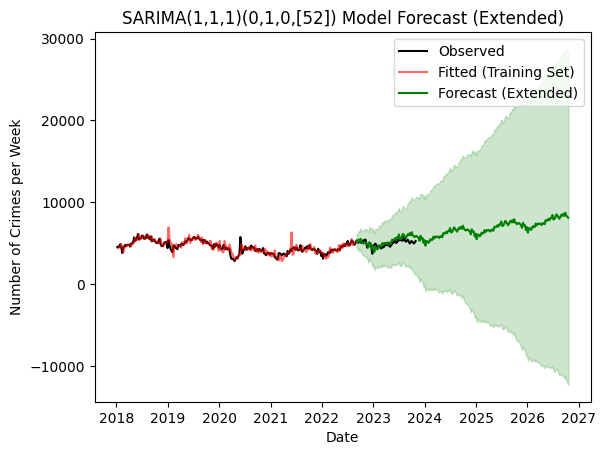

In [57]:
# 3 year forecast
future_dates = pd.date_range(start=test.index[-1], periods=3*52, freq='W')
extended_index = test.index.union(future_dates)

# Get forecast for the extended time index
forecast_sarima_extended = sarima_fit.get_forecast(steps=len(extended_index))

# Get confidence intervals for the extended forecast
ci_extended = forecast_sarima_extended.conf_int()

# Plot the original time series
plt.plot(weekly_data['Number_of_Crimes'], label='Observed', color='black')

# Plot the fitted values on the training set
plt.plot(sarima_fit.fittedvalues.index[1:], sarima_fit.fittedvalues[1:], color='red', label='Fitted (Training Set)', alpha=0.6)

# Plot the forecasted values for the extended period
plt.plot(extended_index, forecast_sarima_extended.predicted_mean, color='green', label='Forecast (Extended)')

# Plot confidence intervals for the extended forecast
plt.fill_between(extended_index, ci_extended.iloc[:, 0], ci_extended.iloc[:, 1], color='green', alpha=0.2)

plt.title('SARIMA(1,1,1)(0,1,0,[52]) Model Forecast (Extended)')
plt.xlabel('Date')
plt.ylabel('Number of Crimes per Week')
plt.legend()
plt.show()

In [21]:
specific_week = pd.to_datetime('2024-09-22')

forecast_for_specific_week = forecast_sarima_extended.predicted_mean.loc[specific_week]

print(f"Forecasted value for {specific_week}: {forecast_for_specific_week}")

Forecasted value for 2024-09-22 00:00:00: 6730.3258773465095
